In [1]:
import pandas as pd
import pdb
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesResampler
import itertools
from IPython.display import display, HTML
from fastdtw import fastdtw
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
pd.set_option('display.max_rows', 500)

In [54]:
data  = pd.read_csv("data/featureslogfile_Budget_500_vs_Budget_500_GPM100_NoSelfPlay.txt", sep = '\t')
#data  = pd.read_csv("data/2Player_FG1E_Supply_AllYears_Traces.txt", sep = ' ')
print(data)
print(data.columns)

      GameID  Player  Round  Turn  CurrentScore  SCORE  SCORE_ADV  ORDINAL  \
0        2.0     0.0    0.0   0.0           3.0   0.06       0.00      0.5   
1        2.0     1.0    0.0   0.0           3.0   0.06       0.00      0.5   
2        2.0     0.0    0.0   1.0           3.0   0.06       0.00      0.5   
3        2.0     1.0    0.0   1.0           3.0   0.06       0.00      0.5   
4        2.0     0.0    1.0   0.0           3.0   0.06       0.00      0.5   
...      ...     ...    ...   ...           ...    ...        ...      ...   
4235    51.0     1.0   18.0   1.0          12.0   0.24      -0.96      1.0   
4236    51.0     0.0   19.0   0.0          39.0   0.78       1.08      0.5   
4237    51.0     1.0   19.0   0.0          12.0   0.24      -1.08      1.0   
4238    51.0     0.0   19.0   1.0          39.0   0.78       0.84      0.5   
4239    51.0     1.0   19.0   1.0          18.0   0.36      -0.84      1.0   

      OUR_TURN  HAS_WON  ...  SENTRY  WITCH  ARTISAN  WOODCUTTE

In [65]:
#LOGS_FROM_TAG = False #if false, logs are from parsed online player logs
LOGS_FROM_TAG = True

NOOFPLAYERS = 100 #note, keep this fixed and dont change it - we always assume there are only two players
agents = ['MCTS_Medium_A', 'MCTS_Medium_B'] #arbitrary labels for players (whether AI based or not)
#agents = ['PlayerA', 'PlayerB']

#if using TAG, parameters for round robin tournament
games_per_matchup = 25
self_play = False
NoOfGames = 2 * games_per_matchup
if self_play == True:
    NoOfGames = 4 * games_per_matchup
    
#if not using TAG, determine no of games 
if LOGS_FROM_TAG == False:
    NoOfGames = data['GameID'].max()  + 1 #GameID starts at zero

In [66]:
#define columns of interest 
#card_types_BigMoneyWithGardens_vs_DoubleWitch = ['GARDENS', 'WITCH', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types_SD = ['ARTISAN', 'BANDIT', 'BUREAUCRAT', 'CHAPEL', 'FESTIVAL', 'GARDENS', 'SENTRY', 'THRONE_ROOM', 'WITCH',
                 'WORKSHOP', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types_FG1E = ['CELLAR','MARKET','MILITIA','MINE','MOAT','REMODEL','SMITHY','VILLAGE',
                'WOODCUTTER','WORKSHOP', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types_BigMoneyWithGardens_vs_DoubleWitch = ['GARDENS', 'WITCH', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types = card_types_SD
index_cols = ['Player', 'GameID'] #used to group traces
non_card_types_round_indep_cols = ['AgentName', 'Win', 'FinalScore', 'TotalRounds'] #additional round indepedent values we want to investigate
cols = index_cols + non_card_types_round_indep_cols + ['Round'] + card_types #final set of cols to keep

In [67]:
#label all games with corresponding agent names
if LOGS_FROM_TAG == True:
    #first generate match-ups
    matchups = []
    if self_play:
        for agent1 in agents:
            for agent2 in agents:
                matchups.append((agent1, agent2))
    else:
        matchups = list(itertools.permutations(agents, 2))

    #function to map gameID to match-up
    def gameID_to_matchup(game_id, player_no, matchup_list, no_games_per_matchup, min_game_id):
        game_group = int((game_id - min_game_id)/no_games_per_matchup)
        matchup = matchup_list[game_group]
        agent1, agent2 = matchup
        if player_no == 0:
            return agent1
        else:
            return agent2

    #add agent names to data set
    min_GameID = data['GameID'].min()
    data['AgentName'] = data.apply(lambda row: gameID_to_matchup(row['GameID'], row['Player'], matchups, games_per_matchup, min_GameID), axis = 1)                         

In [6]:
#we can only record events each turn so we need to use the final turn in each round for each player to determine their
#deck at the end of the round
if LOGS_FROM_TAG:
    print(data['Turn'].unique())
    data = data[data['Turn'] == 1]

[0. 1.]


In [7]:
#all play taces in a single data frame
traces = data.loc[:, cols]
print(traces)

       Player  GameID      AgentName  Win  FinalScore  TotalRounds  Round  \
2         0.0     2.0  MCTS_Medium_A  0.0        29.0         17.0    0.0   
3         1.0     2.0  MCTS_Medium_B  1.0        33.0         17.0    0.0   
6         0.0     2.0  MCTS_Medium_A  0.0        29.0         17.0    1.0   
7         1.0     2.0  MCTS_Medium_B  1.0        33.0         17.0    1.0   
10        0.0     2.0  MCTS_Medium_A  0.0        29.0         17.0    2.0   
...       ...     ...            ...  ...         ...          ...    ...   
23829     1.0   201.0  MCTS_Medium_A  1.0        89.0         51.0   49.0   
23832     0.0   201.0  MCTS_Medium_B  0.0        55.0         51.0   50.0   
23833     1.0   201.0  MCTS_Medium_A  1.0        89.0         51.0   50.0   
23836     0.0   201.0  MCTS_Medium_B  0.0        55.0         51.0   51.0   
23837     1.0   201.0  MCTS_Medium_A  1.0        89.0         51.0   51.0   

       ARTISAN  BANDIT  BUREAUCRAT  ...  THRONE_ROOM  WITCH  WORKSHOP  CURS

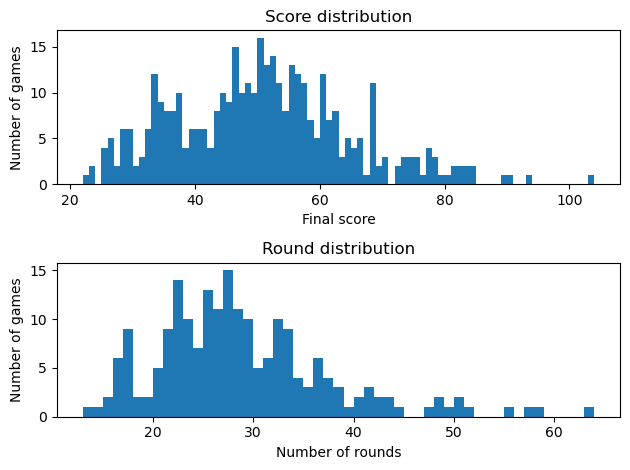

In [79]:
#plot score and round distributions
fig, axs = plt.subplots(2, 1)
grouped_data = traces.groupby('GameID')
score_data = grouped_data['FinalScore'].unique().explode()
axs[0].hist(score_data, bins=np.arange(score_data.min(), score_data.max()+1))
axs[0].set_xlabel('Final score')
axs[0].set_ylabel('Number of games')
axs[0].set_title('Score distribution')
round_data = traces.groupby('GameID')['Round'].max()
axs[1].hist(round_data, bins=np.arange(round_data.min(), round_data.max()+1))
axs[1].set_xlabel('Number of rounds')
axs[1].set_ylabel('Number of games')
axs[1].set_title('Round distribution')
fig.tight_layout() 

No traces before outlier removal: 11788
No traces after outlier removal: 10612
Percentage remaining of original data set: 0.9002375296912114


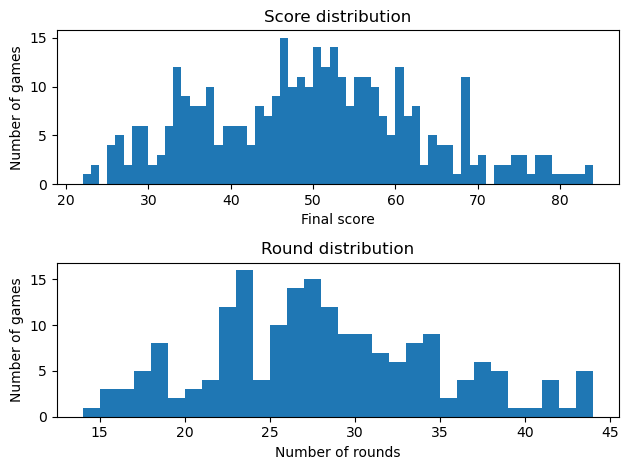

In [81]:
#remove outliers based on thresholds for score and length of game
score_threshold = 85
round_threshold = 45
traces_no_outliers = traces[(traces['FinalScore'] <= score_threshold)
                                           & (traces['TotalRounds'] <= round_threshold)]
#then re-plot score and round distributions
fig, axs = plt.subplots(2, 1)
grouped_data = traces_no_outliers.groupby('GameID')

score_data = grouped_data['FinalScore'].unique().explode()
axs[0].hist(score_data, bins=np.arange(score_data.min(), score_data.max()+1))
axs[0].set_xlabel('Final score')
axs[0].set_ylabel('Number of games')
axs[0].set_title('Score distribution')
round_data = grouped_data['TotalRounds'].unique().explode()
axs[1].hist(round_data, bins=np.arange(round_data.min(), round_data.max()+1))
axs[1].set_xlabel('Number of rounds')
axs[1].set_ylabel('Number of games')
axs[1].set_title('Round distribution')
fig.tight_layout() 

print("No traces before outlier removal: " + str(len(traces)))
print("No traces after outlier removal: " + str(len(traces_no_outliers)))
print("Percentage remaining of original data set: " + str(len(traces_no_outliers)/(1.0*len(traces))))

In [82]:
REMOVE_OUTLIERS = True

if REMOVE_OUTLIERS:
    traces = traces_no_outliers

In [83]:
#format needed is a list of list of vectors
#each row corrsponds to single player's play trace, each entry for a column corresponds
#to the deck composition
#(n_games * n_players, game_length (is variable), (d1,...d17))
list_agents = []
list_traces = []
for gameID in traces['GameID'].unique():
    for player in [0,1]:
        single_player_game = traces[(traces['GameID'] == gameID) & (traces['Player'] == player)]
        single_player_game.sort_values(by = ['Round'])
        single_player_game_cards_no = single_player_game[card_types]
        labelled_matrix = (single_player_game['AgentName'].iloc[0], single_player_game_cards_no.to_numpy())
        list_agents.append(labelled_matrix[0])
        list_traces.append(labelled_matrix[1])

In [84]:
X = to_time_series_dataset(list_traces)

maxNoOfRounds = 0
for series in X:
    if len(X[0]) > maxNoOfRounds:
        maxNoOfRounds = len(X[0])
        
print(maxNoOfRounds)

45


In [85]:
#X = resampled_X
num_clusters = 2
km = TimeSeriesKMeans(n_clusters= num_clusters, metric="dtw", max_iter=50,
                      random_state=0).fit(X)
print(km.labels_)

[0 0 0 0 1 1 1 0 0 0 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 1 0 1 1 0 1 1 1 0 1 0 0
 0 0 0 0 1 1 1 1 0 1 1 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0 1 0 1 0 0 0 1 1
 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 0 1
 1 1 0 0 1 1 0 1 0 1 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1 1 0 0 1 1 0
 1 0 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1
 0 0 1 1 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 0 1 0 1 1 0
 0 1 0 0 1 0 1 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 1 1 0
 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0
 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0
 0 1 0 1 1 1 1 0]


In [86]:
def clusters_dfs(cluster_data, noOfClusters, card_types, max_rounds):
    df_cluster_centres = []
    for cluster in range(0,noOfClusters):
        df_cluster_centres.append(pd.DataFrame(cluster_data[cluster].flatten()).transpose())

    cols = [card_types[i] + "_R" + str(r) for r in range(0, max_rounds) 
            for i in range(0, len(card_types))]

    for cluster in df_cluster_centres:
        cluster.columns = cols

    df_final_centroids = pd.DataFrame(columns  = cols)
    for df in df_cluster_centres:
        df_final_centroids = pd.concat([df_final_centroids, df])
    
    return df_final_centroids
    
df_final_clusters = clusters_dfs(km.cluster_centers_, num_clusters, card_types, maxNoOfRounds)


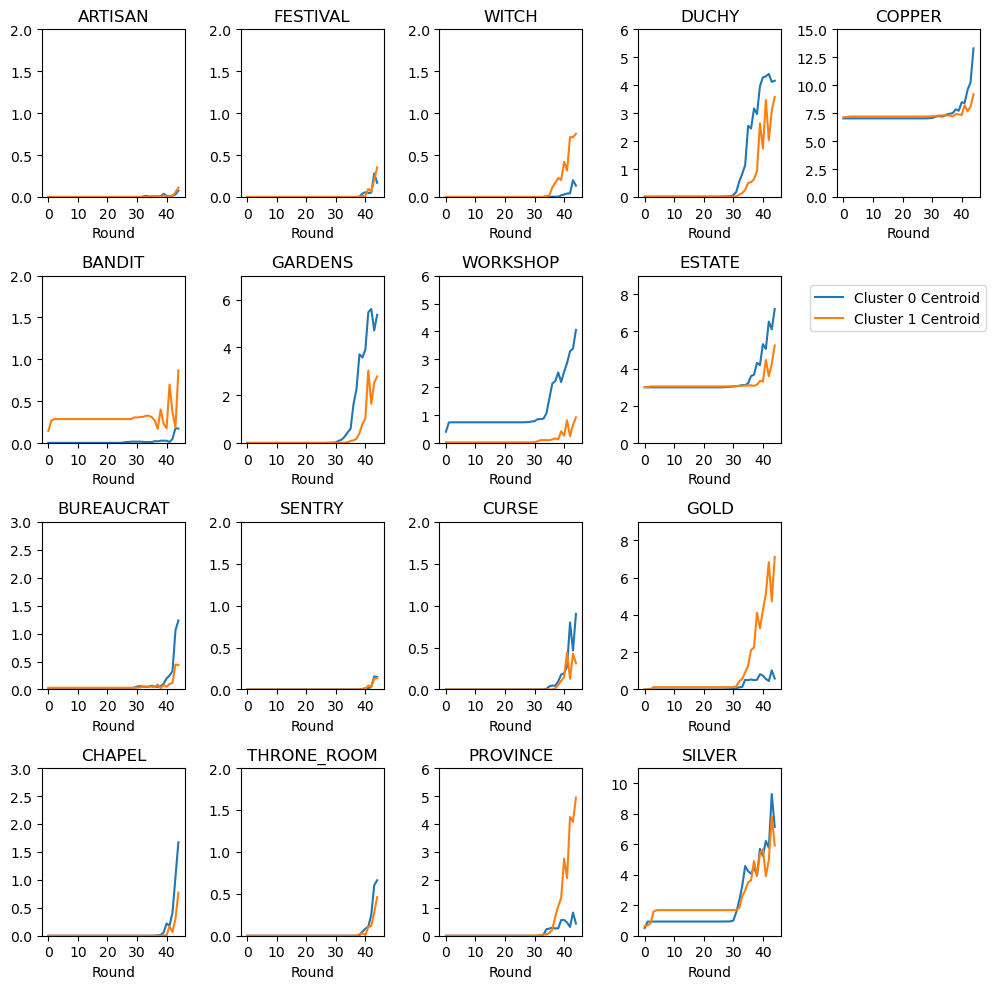

In [87]:
#compare centroids
def deck_evol_comparison(trace_list, label_list, cardTypes, maxRounds, legendOn = True):
    #look at evolution of number of cards of each type per round
    noOfCardTypes = len(cardTypes)
    noOfSubPlotCols = 5
    noOfSubPlotRows = max(2, math.floor(noOfCardTypes/noOfSubPlotCols) + 1)
    fig, axs = plt.subplots(noOfSubPlotRows, noOfSubPlotCols, figsize = (10,10))
    for i in range(0,noOfSubPlotRows):
        for j in range(0,noOfSubPlotCols):
            cardIndex = noOfSubPlotRows*j + i
            if cardIndex >= len(cardTypes):
                axs[i,j].set_visible(False)
            else:
                cardType = cardTypes[cardIndex]
                card_col = [cardType + "_R" + str(r) for r in range(0,maxRounds)]
                card_max = 0
                for (index, trace) in enumerate(trace_list):
                    axs[i,j].plot(range(0,maxRounds), trace[card_col].iloc[0], label = label_list[index])
                    tmp_card_max = int(trace[card_col].iloc[0].max())
                    if tmp_card_max > card_max:
                        card_max = tmp_card_max
                
                #set labels and limits
                axs[i,j].set_title(cardType)
                axs[i,j].set_xlabel('Round')
                axs[i,j].set_ylim((0,card_max+2))
                #axs[i,j].set_ylim((0,card_max))
                axs[i,j].set_xticks(ticks = range(0, maxRounds,10))
            
            #tighten subplots layout
            fig.tight_layout() 
            
    #add overal legend to figure
    if legendOn:
        axs[0,noOfSubPlotRows - 1].legend(loc = (1.2,-0.8))


def plot_cluster_centroids(no_of_clusters, cluster_centre_data, cardTypes, maxRounds):
    trace_list = []
    label_list = []
    for n in range(0, no_of_clusters):
        trace_list.append(pd.DataFrame(cluster_centre_data.iloc[n]).transpose())
        label_list.append(str('Cluster ') + str(n) + str(' Centroid'))
    deck_evol_comparison(trace_list, label_list, cardTypes, maxRounds)

plot_cluster_centroids(num_clusters, df_final_clusters, card_types, maxNoOfRounds)

In [35]:
# Replace X_train with your own time series data
# Make sure X_train is a list of 1D arrays representing time series
# For example, X_train = [np.array([1, 2, 3]), np.array([4, 5, 6]), ...]

X_train = list_traces

# Function to calculate DTW distance
def dtw_distance(ts1, ts2):
    distance, _ = fastdtw(ts1, ts2, dist=euclidean)
    return distance

# Compute DTW distance matrix
dtw_matrix = np.zeros((len(X_train), len(X_train)))
for i in range(len(X_train)):
    if i % 10 == 0:
        print(i)
    for j in range(i, len(X_train)):
        dtw_matrix[i, j] = dtw_distance(X_train[i], X_train[j])
        dtw_matrix[j, i] = dtw_matrix[i, j]

# Set the number of clusters (k)
n_clusters = 2

# Initialize the KMeans model
kmeans = KMeans(n_clusters=n_clusters)

# Fit the model to the DTW distance matrix
kmeans.fit(dtw_matrix)

# Get the cluster assignments for each time series
cluster_assignments = kmeans.labels_

# Print the cluster assignments
print("Cluster Assignments:", cluster_assignments)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
Cluster Assignments: [0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]


/Users/anthonyowen/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [75]:
#def frechet_mean(time_series_set, epsilon=1e-6, max_iter=100):
#    num_series = len(time_series_set)
#    length = 
#    length, _ = time_series_set.shape
#    centroid = np.mean(time_series_set, axis=0)
#    iteration = 0

#    while True:
#        distances = np.zeros((num_series, length))
#
#        for i in range(num_series):
#            distances[i] = [dtw_distance(time_series_set[i], centroid)]

#        closest_series = np.argmin(distances, axis=0)
#        new_centroid = np.mean(time_series_set[closest_series], axis=0)

#        if np.sum(np.abs(new_centroid - centroid)) < epsilon or iteration >= max_iter:
#           break

#        centroid = new_centroid
#        iteration += 1

#    return centroid

# Example time series data
#caclulate centroid for particular cluster
#cluster = 0

# Calculate the Fréchet mean
#frechet_mean_result = frechet_mean(X_train)

# The shape of frechet_mean_result will be (n_timestamps, n_features)
#print("Fréchet Mean Shape:", frechet_mean_result.shape)

#print(frechet_mean_result)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (400,) + inhomogeneous part.